In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from einops import rearrange
import cv2
import os
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# Simple Programming and Exploratory Analysis 

## Images

In [2]:
# Define a transform to convert images to tensors
transform = transforms.ToTensor()

# Download the MNIST dataset using torchvision
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Extract data and labels, convert to numpy arrays
# Stack all image tensors into a single tensor, then convert to numpy
images_np = mnist_train.data.numpy().reshape(-1, 28*28) # Reshape 28x28 images to 784-length vectors
labels_np = mnist_train.targets.numpy()
random_indices = np.random.randint(0, len(images_np), 1000)
sample_imgs = images_np[random_indices]
sample_labels = labels_np[random_indices]
print("Sample shape: ", sample_imgs.shape)
print("Label shape: ", sample_labels.shape)

Sample shape:  (1000, 784)
Label shape:  (1000,)


In [3]:
# Reshape images_np to (num_images, channels, height, width)
# MNIST images are 28x28 grayscale, so channels = 1
images_reshaped = sample_imgs.reshape(-1, 1, 28, 28)

# Define a batch size
batch_size = 25

# Calculate the number of images that can form full batches
num_full_batches = images_reshaped.shape[0] // batch_size
num_images_for_batching = num_full_batches * batch_size

# Use only images that can form full batches
images_for_batching = images_reshaped[:num_images_for_batching]

# Use einops.rearrange to batch the data
# This will create batches of (batch_of_batches, batch_size, channels, height, width)
batched_images = rearrange(images_for_batching, '(b n) c h w -> b n c h w', n=batch_size)

print(f"Original images_np shape: {images_np.shape}")
print(f"Reshaped images for einops (before slicing): {images_reshaped.shape}")
print(f"Number of images used for batching: {num_images_for_batching}")
print(f"Batched images shape using einops (batch_of_batches, batch_size, channels, height, width): {batched_images.shape}")

Original images_np shape: (60000, 784)
Reshaped images for einops (before slicing): (1000, 1, 28, 28)
Number of images used for batching: 1000
Batched images shape using einops (batch_of_batches, batch_size, channels, height, width): (40, 25, 1, 28, 28)


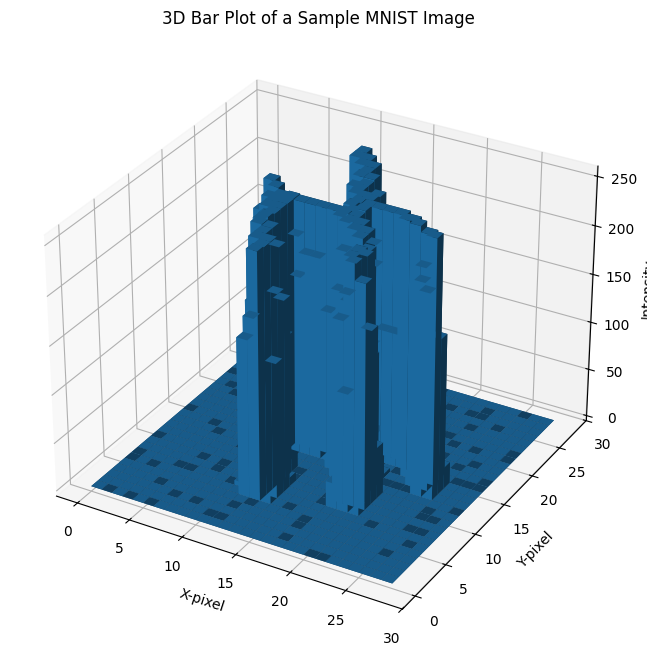

In [4]:
from mpl_toolkits.mplot3d import Axes3D

sample_image = batched_images[0, 0, 0, :, :]

# Create a figure and a 3D subplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare data for 3D bar plot
xpos, ypos = np.meshgrid(np.arange(sample_image.shape[0]), np.arange(sample_image.shape[1]))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = dy = 1 * np.ones_like(xpos)
dz = sample_image.flatten()

# Plot the 3D bars
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax.set_xlabel('X-pixel')
ax.set_ylabel('Y-pixel')
ax.set_zlabel('Intensity')
ax.set_title('3D Bar Plot of a Sample MNIST Image')

plt.show()



## Time Series

In [5]:
energy_df = pd.read_csv('data/energydata_complete.csv')
energy_df['date'] = pd.to_datetime(energy_df['date'])
energy_df['NSM'] = energy_df['date'].dt.hour * 3600 + energy_df['date'].dt.minute*60 + energy_df['date'].dt.second
energy_df.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0 2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1 2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2 2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3 2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4 2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...   RH_9     T_out  Press_mm_hg  RH_out  \
0  19.79  44.730000  19.000000  ...  45.53  6.600000        733.5    92.0   
1  19.79  44.790000  19.000000  ...  45.56  6.483333        733.6    92.0   
2  19.79  44.933333  18.926667  ...  45.50  6.366667        733.7    92.0   
3  19.79  45.000000  18.890000  ...  45.40  6.250000        733.8    92.0   
4  19.79  45.000000  18.890000  ...  45.40  6.133333        733.9    92.0   

   Windspeed  Visibility  Tdewpoint        rv1        rv2    NSM  
0   7.000000   63.000000        5.3  13.275433  13.275433  61200  
1   6.666667   59.166667        5.2  18.606195  18.606195  61800  
2   6.333333   55.333333        5.1  28.642668  28.642668  62400  
3   6.000000   51.500000        5.0  45.410389  45.410389  63000  
4   5.666667   47.666667        4.9  10.084097  10.084097  63600  

[5 rows x 30 columns]

Text(0.5, 1.0, 'Appliances Energy Consumption Over Time')

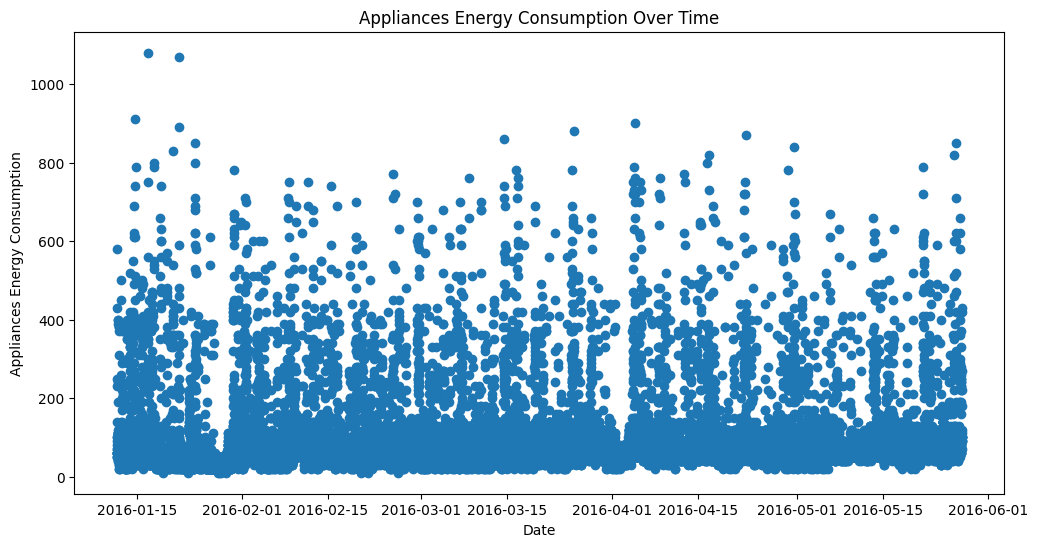

In [6]:
plt.figure(figsize=(12, 6))
plt.scatter(energy_df['date'], energy_df['Appliances'])
plt.xlabel('Date')
plt.ylabel('Appliances Energy Consumption')
plt.title('Appliances Energy Consumption Over Time')

Text(0.5, 1.0, 'Appliances Energy Consumption from Feb 1 to Feb 7, 2016')

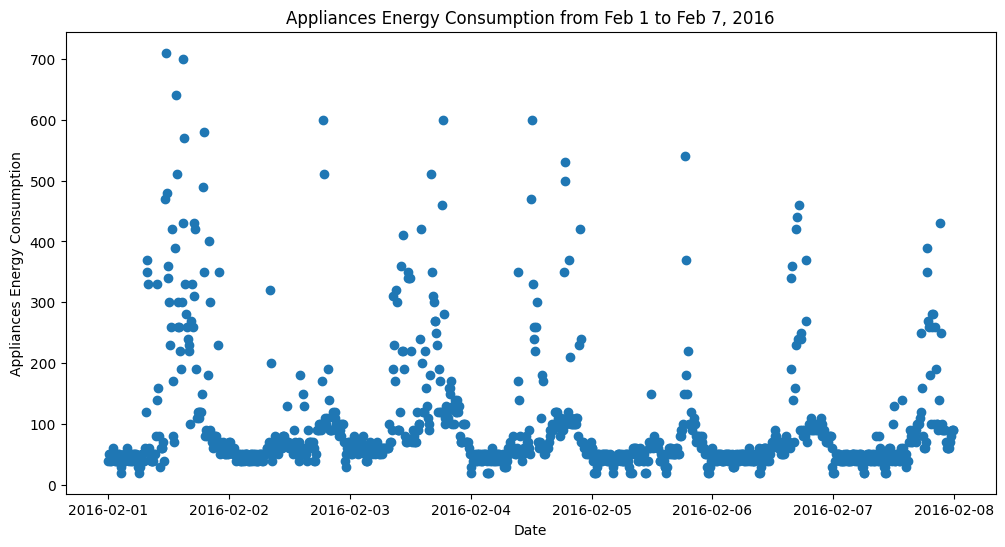

In [7]:
start_date = '2016-02-01'
end_date = '2016-02-08'
week_data = energy_df[(energy_df['date'] >= start_date) & (energy_df['date'] < end_date)]
plt.figure(figsize=(12, 6))
plt.scatter(week_data['date'], week_data['Appliances'])
plt.xlabel('Date')
plt.ylabel('Appliances Energy Consumption')
plt.title('Appliances Energy Consumption from Feb 1 to Feb 7, 2016')

C:\Users\manas\AppData\Local\Temp\ipykernel_67948\1087069922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_data['hour'] = week_data['date'].dt.hour
C:\Users\manas\AppData\Local\Temp\ipykernel_67948\1087069922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_data['day'] = week_data['date'].dt.day_name()
C:\Users\manas\AppData\Local\Temp\ipykernel_67948\1087069922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

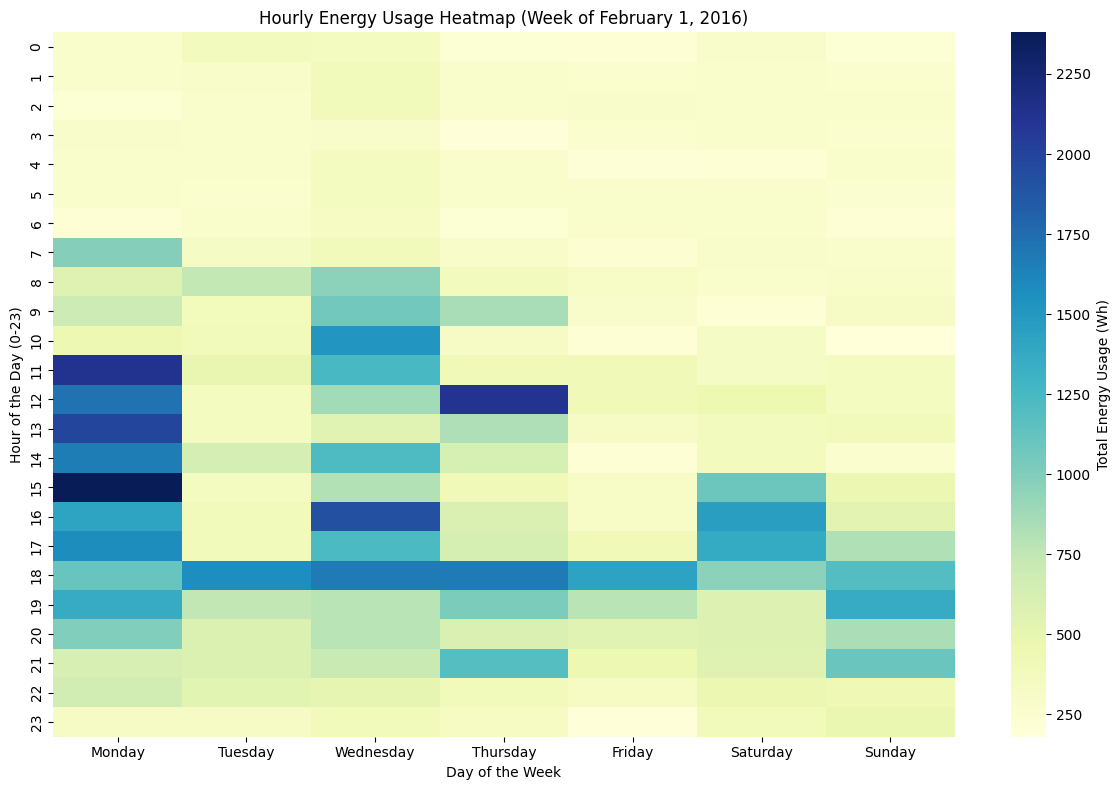

In [8]:
week_data['hour'] = week_data['date'].dt.hour
week_data['day'] = week_data['date'].dt.day_name()
week_data['day_index'] = week_data['date'].dt.dayofweek
hourly_data = week_data.groupby(['day_index', 'day', 'hour'])['Appliances'].sum().reset_index()
heatmap_pivot = hourly_data.pivot(index='hour', columns='day', values='Appliances')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_pivot = heatmap_pivot[days_order]
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Total Energy Usage (Wh)'})

plt.title('Hourly Energy Usage Heatmap (Week of February 1, 2016)')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day (0-23)')
plt.tight_layout()
plt.show()

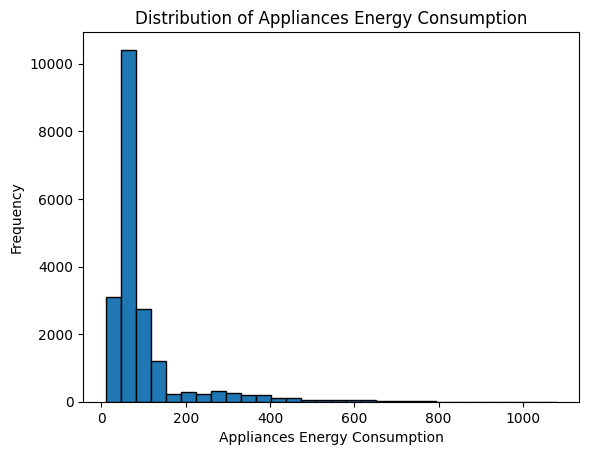

In [9]:
plt.hist(energy_df['Appliances'], bins=30, edgecolor='black')
plt.xlabel('Appliances Energy Consumption')
plt.ylabel('Frequency')
plt.title('Distribution of Appliances Energy Consumption')
plt.show()

C:\Users\manas\AppData\Local\Temp\ipykernel_67948\1360170901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_data['NSM'] = week_data['date'].dt.hour * 3600 + week_data['date'].dt.minute*60 + week_data['date'].dt.second


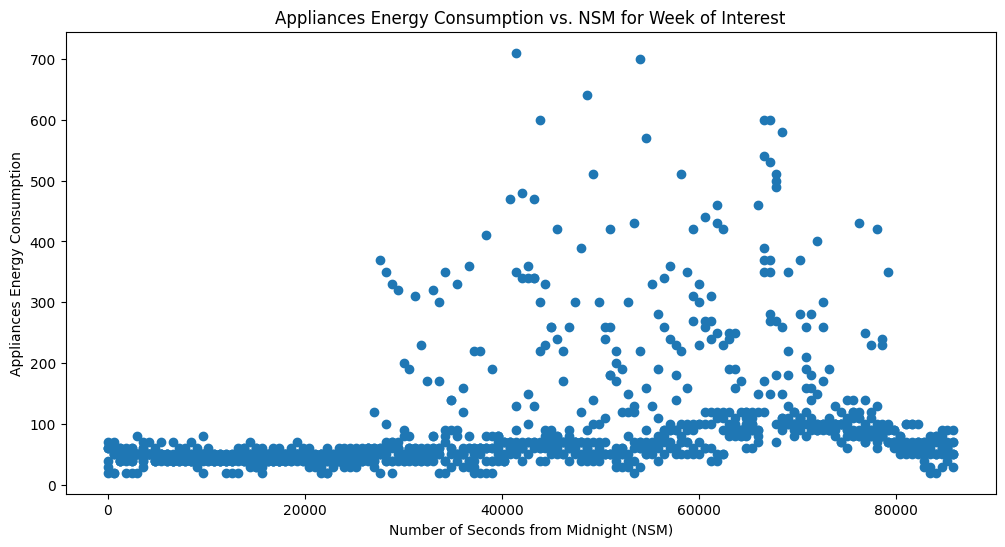

In [10]:
week_data['NSM'] = week_data['date'].dt.hour * 3600 + week_data['date'].dt.minute*60 + week_data['date'].dt.second
plt.figure(figsize=(12, 6))
plt.scatter(week_data['NSM'], week_data['Appliances'])
plt.xlabel('Number of Seconds from Midnight (NSM)')
plt.ylabel('Appliances Energy Consumption')
plt.title('Appliances Energy Consumption vs. NSM for Week of Interest')
plt.show()

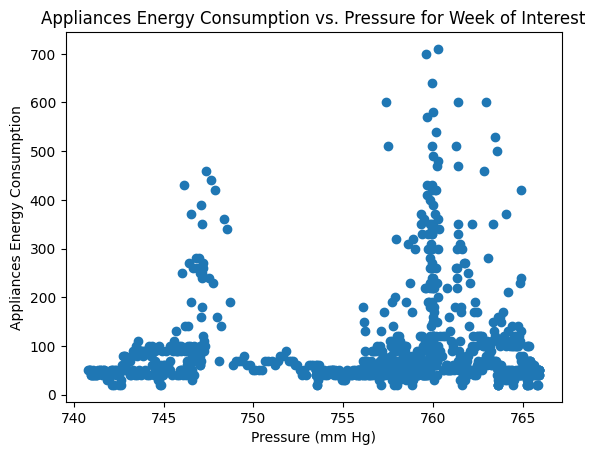

In [11]:
plt.scatter(week_data['Press_mm_hg'], week_data['Appliances'])
plt.xlabel('Pressure (mm Hg)')
plt.ylabel('Appliances Energy Consumption')
plt.title('Appliances Energy Consumption vs. Pressure for Week of Interest')
plt.show()

In [12]:
energy_df['NSMxPress_mm_hg'] = energy_df['NSM'] * energy_df['Press_mm_hg'] # Engineering new feature by multiplying NSM and Pressure
energy_df.corr()['Appliances'].abs().sort_values(ascending=False)

Appliances         1.000000
NSM                0.217152
NSMxPress_mm_hg    0.216453
lights             0.197278
RH_out             0.152282
T2                 0.120073
T6                 0.117638
T_out              0.099155
RH_8               0.094039
Windspeed          0.087122
RH_1               0.086031
T3                 0.085060
RH_6               0.083178
RH_2               0.060465
RH_7               0.055642
T1                 0.055447
RH_9               0.051462
T4                 0.040281
T8                 0.039572
RH_3               0.036292
Press_mm_hg        0.034885
T7                 0.025801
T5                 0.019760
RH_4               0.016965
Tdewpoint          0.015353
rv1                0.011145
rv2                0.011145
T9                 0.010010
date               0.009630
RH_5               0.006955
Visibility         0.000230
Name: Appliances, dtype: float64

In [13]:
from sklearn.ensemble import RandomForestRegressor
X = energy_df.drop(columns=['Appliances', 'date'])
y = energy_df['Appliances']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(importances[:15])

Feature Importances:
NSMxPress_mm_hg    0.143230
T3                 0.056172
NSM                0.049247
RH_3               0.045113
RH_5               0.040458
Press_mm_hg        0.039618
T8                 0.038569
RH_2               0.036842
RH_1               0.032964
Tdewpoint          0.031874
lights             0.029925
RH_4               0.029419
RH_8               0.029398
RH_6               0.029219
T9                 0.028910
dtype: float64


### Comments about Feature Importance
- NSM is an important feature, having the highest correlation as well as Random Forest based feature importance. 
- Press_mm_hg is an important feature but not directly. The NSM &times; Press_mm_hg becomes a much more important feature having a higher predictive power. 

## Multivariate

In [14]:
df = pd.read_csv('data/airfoil_self_noise.dat', sep = '\s+', header = None, names = ['frequency', 'attack_angle', 'chord_length', 'velocity_fs', 'ss_displacement', 'sound_pressure'])
for col in df.columns:
  print('\nColumn:',col)
  print("Mean:", df[col].mean())
  print("Standard Deviation:", df[col].std())
  print("Median:", df[col].median())
  print("Kurtosis:",df[col].kurtosis())
  print("Skewness:",df[col].skew())
  print("Range:", df[col].min(),',',df[col].max())


Column: frequency
Mean: 2886.3805721889553
Standard Deviation: 3152.5731369306686
Median: 1600.0
Kurtosis: 5.708685076629566
Skewness: 2.1370843370561032
Range: 200 , 20000

Column: attack_angle
Mean: 6.782302062541583
Standard Deviation: 5.918128124886475
Median: 5.4
Kurtosis: -0.4129507932946681
Skewness: 0.6891644015246552
Range: 0.0 , 22.2

Column: chord_length
Mean: 0.13654823685961412
Standard Deviation: 0.09354072837396629
Median: 0.1016
Kurtosis: -1.037964096539102
Skewness: 0.4574574796795428
Range: 0.0254 , 0.3048

Column: velocity_fs
Mean: 50.86074517631405
Standard Deviation: 15.57278439538569
Median: 39.6
Kurtosis: -1.5639512742591497
Skewness: 0.23585241419124836
Range: 31.7 , 71.3

Column: ss_displacement
Mean: 0.011139880391217565
Standard Deviation: 0.013150234266814775
Median: 0.00495741
Kurtosis: 2.218903124436665
Skewness: 1.7021645560889562
Range: 0.000400682 , 0.0584113

Column: sound_pressure
Mean: 124.83594278110448
Standard Deviation: 6.898656621628731
Median:

# Image Processing

## Image Pre-processing and transformation

In [15]:
def transform_image(rgb_image, rot, shift, scale, warp_factor):
    rows, cols, ch = rgb_image.shape
    
    center = (cols / 2, rows / 2)
    M_affine = cv2.getRotationMatrix2D(center, rot, scale)
    
    M_affine[0, 2] += shift[0]
    M_affine[1, 2] += shift[1]
    
    affine_out = cv2.warpAffine(rgb_image, M_affine, (cols, rows))
    
    src_pts = np.float32([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]])
    
    dst_pts = np.float32([
        [0 + warp_factor, 0], 
        [cols - 1 - warp_factor, 0], 
        [0, rows - 1], 
        [cols - 1, rows - 1]
    ])
    
    M_perspective = cv2.getPerspectiveTransform(src_pts, dst_pts)
    final_output = cv2.warpPerspective(affine_out, M_perspective, (cols, rows))
    
    return final_output

In [16]:
for img_path in os.listdir('data/Agricultural_Image_Analytics/leaves/'):
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img = cv2.imread(os.path.join('data/Agricultural_Image_Analytics/leaves', img_path))
    for i in range(13):
        rot = np.random.uniform(-90, 90)  # Random rotation between -90 and 90 degrees
        shift = (np.random.uniform(-20, 20), np.random.uniform(-20, 20))  # Random shift in x and y
        scale = np.random.uniform(0.8, 1.5)  # Random scale between 0.8 and 1.5
        warp_factor = np.random.uniform(0, 10)  # Random warp factor for perspective transformation
        transformed_img = transform_image(img, rot=rot, shift=shift, scale=scale, warp_factor=warp_factor)
        cv2.imwrite(os.path.join('data/Agricultural_Image_Analytics/leaves', f'transformed_{i}_{img_path}'), transformed_img)

In [17]:
def zca_whiten_channel(channel_data, patch_size=(5, 5), epsilon=0.1):
    channel_data = channel_data.astype(np.float32)
    
    patches = extract_patches_2d(channel_data, patch_size)
    n_patches = patches.shape[0]
    
    patches_flat = patches.reshape(n_patches, -1)
    
    mean = np.mean(patches_flat, axis=0)
    patches_centered = patches_flat - mean
    
    sigma = np.cov(patches_centered, rowvar=False)
    U, S, V = np.linalg.svd(sigma)
    
    zca_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))
    
    patches_whitened = np.dot(patches_centered, zca_matrix)
    patches_reshaped = patches_whitened.reshape(n_patches, *patch_size)
    
    return reconstruct_from_patches_2d(patches_reshaped, channel_data.shape)

input_dir = 'data/Agricultural_Image_Analytics/leaves/'
output_dir = 'data/Agricultural_Image_Analytics/leaves/whitened/'
os.makedirs(output_dir, exist_ok=True)

for img_name in os.listdir(input_dir):
    if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
        
    img = cv2.imread(os.path.join(input_dir, img_name))
    if img is None: continue
    
    whitened_rgb = np.zeros(img.shape, dtype=np.float32)
    for i in range(3):
        whitened_rgb[:, :, i] = zca_whiten_channel(img[:, :, i], patch_size=(5, 5), epsilon=1.0)

    for i in range(3):
        ch = whitened_rgb[:, :, i]
        ch = np.clip(ch, np.percentile(ch, 2), np.percentile(ch, 98))
        whitened_rgb[:, :, i] = cv2.normalize(ch, None, 0, 255, cv2.NORM_MINMAX)

    cv2.imwrite(os.path.join(output_dir, img_name), whitened_rgb.astype(np.uint8))

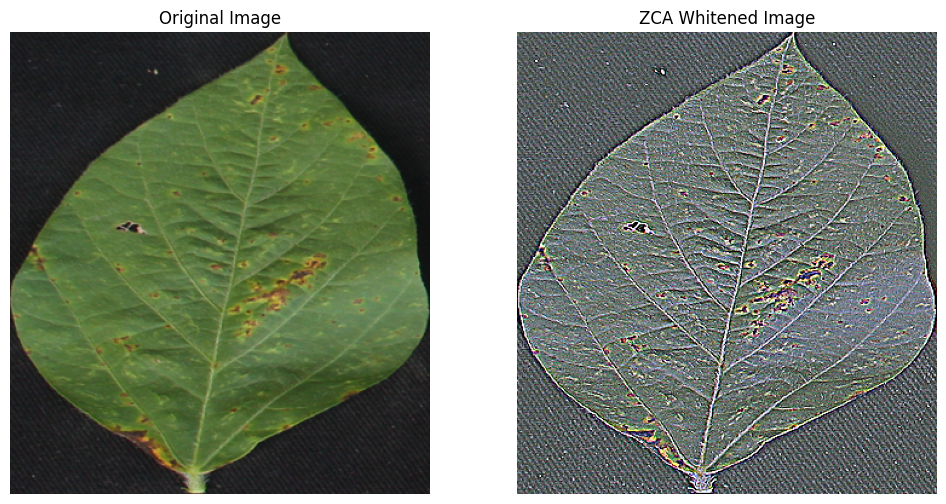

In [18]:
# Consider image: l5.png
img = cv2.imread('data/Agricultural_Image_Analytics/leaves/I5.png')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
whitened_img = cv2.imread('data\Agricultural_Image_Analytics\leaves\whitened\I5.png')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(rgb_img)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(whitened_img, cv2.COLOR_BGR2RGB))
axes[1].set_title('ZCA Whitened Image')
axes[1].axis('off')
plt.show()

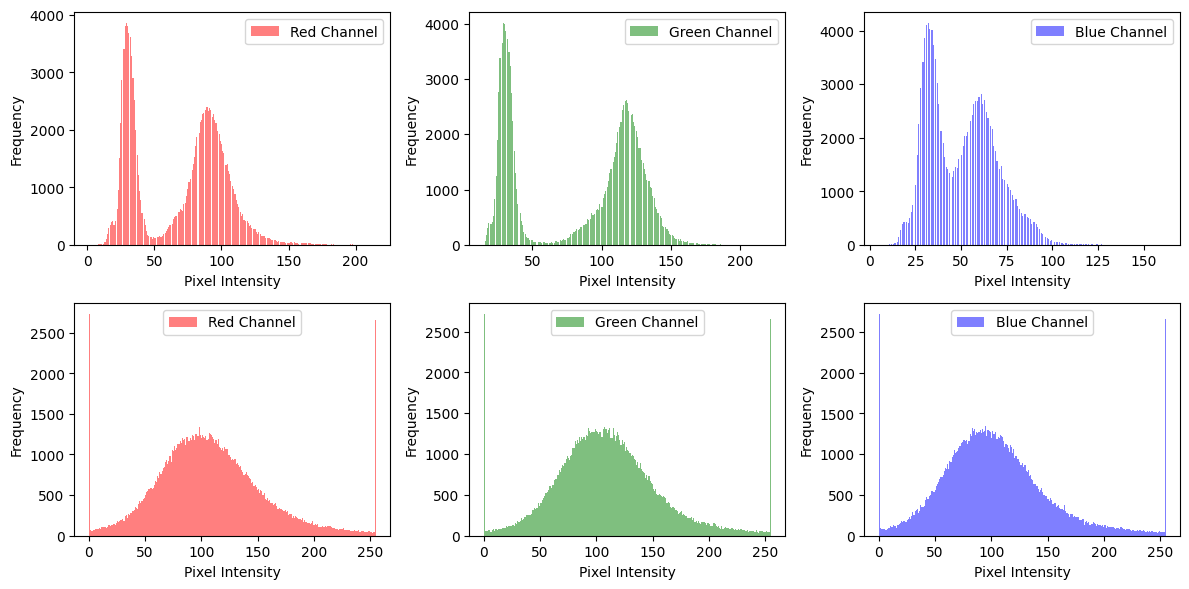

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0][0].hist(rgb_img[:, :, 0].flatten(), bins=256, color='red', alpha=0.5, label='Red Channel')
axes[0][1].hist(rgb_img[:, :, 1].flatten(), bins=256, color='green', alpha=0.5, label='Green Channel')
axes[0][2].hist(rgb_img[:, :, 2].flatten(), bins=256, color='blue', alpha=0.5, label='Blue Channel')
axes[0][0].set_xlabel('Pixel Intensity')
axes[0][0].set_ylabel('Frequency')
axes[0][0].legend()
axes[0][1].set_xlabel('Pixel Intensity')
axes[0][1].set_ylabel('Frequency')
axes[0][1].legend()
axes[0][2].set_xlabel('Pixel Intensity')
axes[0][2].set_ylabel('Frequency')
axes[0][2].legend()
axes[1][0].hist(whitened_img[:, :, 0].flatten(), bins=256, color='red', alpha=0.5, label='Red Channel')
axes[1][1].hist(whitened_img[:, :, 1].flatten(), bins=256, color='green', alpha=0.5, label='Green Channel')
axes[1][2].hist(whitened_img[:, :, 2].flatten(), bins=256, color='blue', alpha=0.5, label='Blue Channel')
axes[1][0].set_xlabel('Pixel Intensity')
axes[1][1].set_xlabel('Pixel Intensity')
axes[1][2].set_xlabel('Pixel Intensity')
axes[1][0].set_ylabel('Frequency')
axes[1][1].set_ylabel('Frequency')
axes[1][2].set_ylabel('Frequency')
axes[1][0].legend()
axes[1][1].legend()
axes[1][2].legend()
plt.tight_layout()
plt.show()

## Image Segmentation

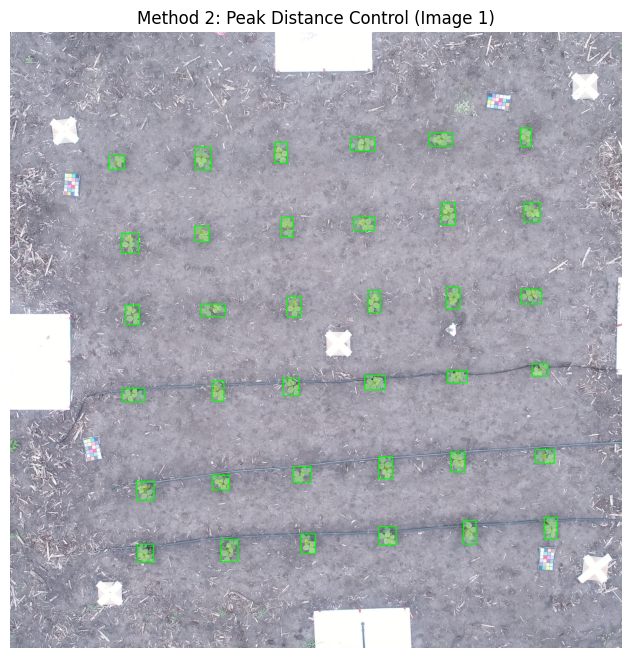

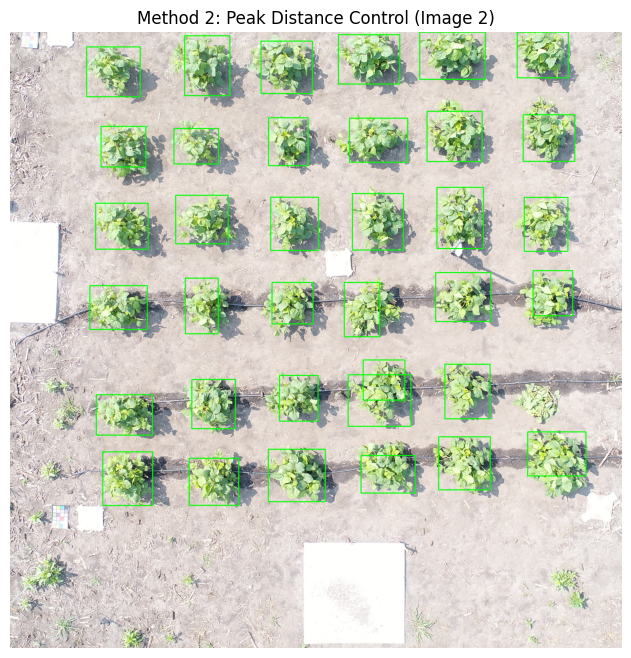

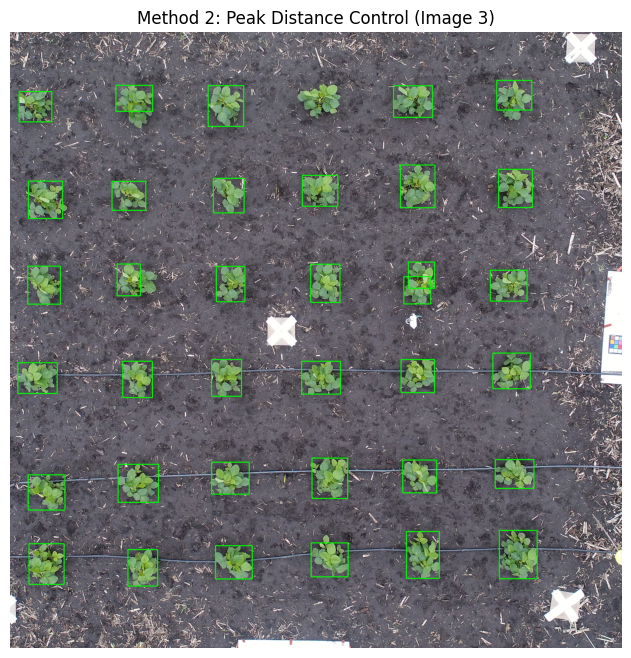

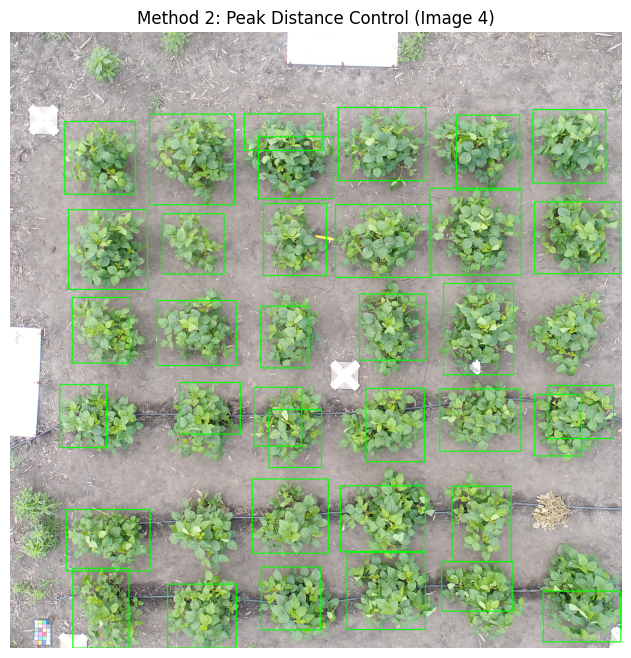

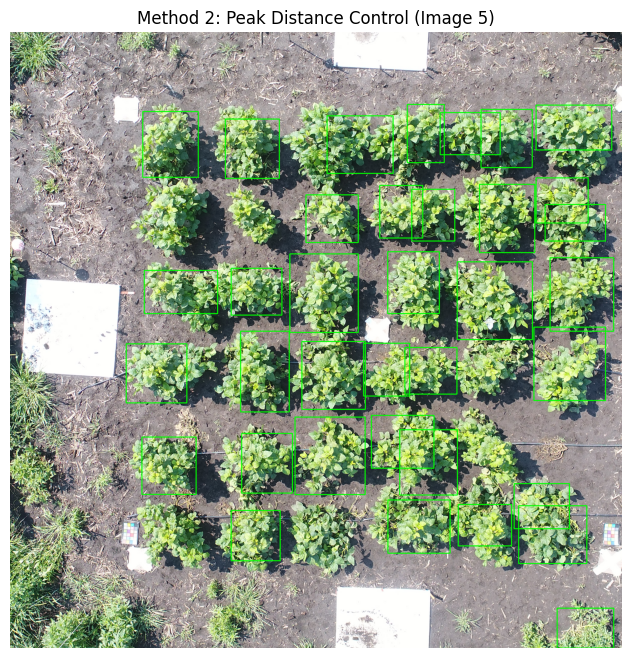

In [20]:


def segment_subplot(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([90, 255, 255])
    
    mask = cv2.inRange(hsv, lower_green, upper_green) 
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    return mask

def getROI(img):
    """Crops the image to the experimental field."""
    height, width = img.shape[:2]
    return img[int(0.22*height):int(0.81*height), int(0.1*width):int(0.88*width)]

input_dir = 'data/Agricultural_Image_Analytics/subplots/'
MIN_DISTANCE_PEAKS = 75 

for i in range(1, 6):
    file_path = os.path.join(input_dir, f'{i}.JPG')
    raw_img = cv2.imread(file_path)
    
    if raw_img is None:
        continue
        
    img_roi = getROI(raw_img)
    mask_cleaned = segment_subplot(img_roi)
    
    distance = ndimage.distance_transform_edt(mask_cleaned)
    
    local_maxi = peak_local_max(distance, 
                                min_distance=MIN_DISTANCE_PEAKS, 
                                labels=mask_cleaned)
    
    markers = np.zeros(distance.shape, dtype=int)
    for idx, (r, c) in enumerate(local_maxi):
        markers[r, c] = idx + 1
        
    labels = watershed(-distance, markers, mask=mask_cleaned)
    slices = ndimage.find_objects(labels)

    all_candidates = []
    for s in slices:
        if s is not None:
            h = s[0].stop - s[0].start
            w = s[1].stop - s[1].start
            area = h * w
            if area > 200: 
                cy, cx = (s[0].start + s[0].stop) / 2, (s[1].start + s[1].stop) / 2
                all_candidates.append({'slice': s, 'area': area, 'center': (cx, cy)})

    all_candidates.sort(key=lambda x: x['area'], reverse=True)
    final_36 = all_candidates[:36]

    if len(final_36) > 0:
        avg_h = np.mean([c['slice'][0].stop - c['slice'][0].start for c in final_36])
        row_tol = avg_h * 0.7  
        
        final_36.sort(key=lambda c: (c['center'][1] // row_tol, c['center'][0]))

    output_img = img_roi.copy()
    for idx, b in enumerate(final_36):
        s = b['slice']
        cv2.rectangle(output_img, (s[1].start, s[0].start), (s[1].stop, s[0].stop), (0, 255, 0), 4)
        

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Method 2: Peak Distance Control (Image {i})")
    plt.axis('off')
    plt.show()